In [17]:
#!pip install tweet-preprocessor      

  Running setup.py bdist_wheel for tweet-preprocessor ... done
  Stored in directory: /Users/JackNelson/Library/Caches/pip/wheels/64/d9/5c/c72815d52f5770f229b909840516fd7a36e11bd57d4b8f28dd
Successfully built tweet-preprocessor


In [1]:
import pandas as pd
df = pd.read_csv('data/csv_daily/Bitcoin/20180305.csv',lineterminator='\n')
#print df.head(5)
print df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71948 entries, 0 to 71947
Data columns (total 15 columns):
Unnamed: 0              71948 non-null int64
id                      71948 non-null int64
text                    71948 non-null object
created_at              71948 non-null object
retweet_count           71948 non-null int64
favorite_count          71948 non-null int64
source                  71948 non-null object
user_id                 71948 non-null int64
user_screen_name        71948 non-null object
user_name               71947 non-null object
user_created_at         71948 non-null object
user_description        52057 non-null object
user_followers_count    71948 non-null int64
user_friends_count      71948 non-null int64
user_location           41961 non-null object
dtypes: int64(7), object(8)
memory usage: 8.2+ MB
None


In [43]:
import pandas as pd
import preprocessor as p
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

class DailySentiment:
    def __init__(self):
        # instantiate tweet tokenizer from nltk.tokenize, set to remove handles and reduce repeating characters
        self._tweetProcessor = TweetTokenizer(strip_handles=False, reduce_len=True)
        # instantiate sentiment intensity analyzer from nltk.sentiment.vader
        self._vaderAnalyzer = SentimentIntensityAnalyzer()
    
    # External function to return average VADER polarity score
    # getDailySentiment(df = dataframe, keyword = string, filterTweets = boolean, noninfluence = boolean)
    # keyword: search term tweets were queried with
    # filterTweets and noninfluence: booleans to run/skip particular preprocessing function
    def getDailySentiment(self, df, keyword=None, filterTweets=True, noninfluence=True):
        scores = self.getSentimentScores(df, keyword, filterTweets, noninfluence)
        
        avg_scores = {'neg': sum(score['neg'] for score in scores) / len(scores),
                      'neu': sum(score['neu'] for score in scores) / len(scores),
                      'pos': sum(score['pos'] for score in scores) / len(scores),
                      'compound': sum(score['compound'] for score in scores) / len(scores)}
        return avg_scores
    
    # External function to return a list of true VADER polarity scores greater than their neutral score value
    # getTrueSentimentScores(df = dataframe, keyword = string, filterTweets = boolean, noninfluence = boolean)
    # keyword: search term tweets were queried with
    # filterTweets and noninfluence: booleans to run/skip particular preprocessing function
    def getTrueSentimentScores(self, df, keyword=None, filterTweets=True, noninfluence=True, neu=False):
        if (filterTweets or keyord != None):
            df = self._filterTweets(df, keyword)
        if noninfluence:
            df = self._removeNoninfluencers(df)
            
        list_of_tweets = df.text
        true_scores = []
        for tweet in list_of_tweets:
            tweet = self._cleanTweet(tweet)
            score = self._vaderAnalyzer.polarity_scores(tweet)
            if (score.get('neu')<score.get('pos') and score.get('neu')<score.get('neg')) or neu:
                if (score.get('pos')>score.get('neg')):
                    true_scores.append(score.get('pos'))
                else:
                    true_scores.append(-1*score.get('neg'))
        return true_scores
    
    # External function to return a list of VADER polarity scores
    # getSentimentScores(df = dataframe, keyword = string, filterTweets = boolean, noninfluence = boolean)
    # keyword: search term tweets were queried with
    # filterTweets and noninfluence: booleans to run/skip particular preprocessing function
    def getSentimentScores(self, df, keyword=None, filterTweets=True, noninfluence=True):
        if (filterTweets or keyword != None):
            df = self._filterTweets(df, keyword)
        if noninfluence:
            df = self._removeNoninfluencers(df)
        
        list_of_tweets = df.text
        scores = []
        for tweet in list_of_tweets:
            tweet = self._cleanTweet(tweet)
            scores.append(self._vaderAnalyzer.polarity_scores(tweet))
        return scores        
    
    # Internal function to remove tweets without keyword (BUG FIX)
    # _filterTweets(df = dataframe, keyword = string)
    def _filterTweets(self, df, keyword):
        df_filtered = df[df.text.str.contains(keyword)]
        return df_filtered
        
    # Internal function to remove tweets from users below a follower threshold
    # _removedNoninfluencers(df = dataframe, min_follower = int <-defaulted to 100)
    def _removeNoninfluencers(self, df, min_follower = 100):
        df_filtered = df[df.user_followers_count > min_follower]
        return df_filtered
    
    # Internal function that goes through several text preprocessing steps
    # _cleanTweet(tweet = string)
    def _cleanTweet(self, tweet):
        # set preprocessor to remove links, mentions, and reserved words (FAV, RT, etc.)
        p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
        # clean tweet with preprocessor and remove hashtags
        tweet = p.clean(tweet.translate(None, "#"))

        return tweet    

In [44]:
import os
import re
    
class SentimentsPerDay:
    def __init__(self, crypto):
        # assign folder_name to class
        self.crypto = crypto
        # instantiate DailySentiment class
        self._dailySentiment = DailySentiment()
    
    # external function returning list of true raw sentiment score list for each file in folder
    def getTrueRawSentimentsPerDay(self, neu=False):
        _files = self.getFiles()
        
        daily_true_sentiments_raw = {}
        for _file in _files:
            path = 'data/csv_daily/' + self.crypto + '/' + _file
            df = pd.read_csv(path,lineterminator='\n')
            print _file
            day = re.search("\d{8}",_file).group(0)
            daily_true_sentiments_raw[day] = (self._dailySentiment.getTrueSentimentScores(df, self.crypto, neu=neu))
            
        return daily_true_sentiments_raw
    
    # external function returning list of sentiment scores for each file in folder    
    def getSentimentsPerDay(self):
        _files = self.getFiles()
        
        daily_sentiments = []    
        for _file in _files:
            path = "data/csv_daily/" + self.crypto + "/" +_file
            df = pd.read_csv(path,lineterminator='\n')
            daily_sentiments.append(self._dailySentiment.getDailySentiment(df, self.crypto))
                
        return daily_sentiments
            
    # internal function extracting list of csv files in folder
    def getFiles(self):
        # construct folder path where files reside
        folder_name = "/data/csv_daily/"
        path = str(os.getcwd()) + folder_name + self.crypto
        # using regex expression to only take file_names (instead of full paths)
        reg = re.compile("\d{8}")
            
        # loop to generate list of all files in folder that fit naming convention
        _files = []
        for csv_path in os.listdir(path):
            if reg.search(csv_path):
                 _files.append(csv_path)
        return _files          

## Bitcoin

#### neutral filtered

In [33]:
BitcoinDailyAnalyzer = SentimentsPerDay('Bitcoin')
BitcoinSentiments_true = BitcoinDailyAnalyzer.getTrueRawSentimentsPerDay()
print BitcoinSentiments_true

20180304.csv
20180305.csv
20180306.csv
20180307.csv
20180308.csv
20180309.csv
20180310.csv
20180311.csv
20180312.csv
20180313.csv
20180314.csv
20180315.csv
20180316.csv
20180317.csv
20180318.csv
20180319.csv
20180320.csv
20180321.csv
20180323.csv
20180324.csv
{'20180315': [], '20180314': [], '20180317': [0.37, -0.43, -0.397, -0.453, -0.453], '20180316': [], '20180306': [0.433, -0.594, -0.414, 0.418, 0.555], '20180307': [-0.395, -0.392, -0.442], '20180304': [-0.335, -0.442, -0.422], '20180305': [-0.395, -0.442, -0.407, -0.407, -0.407, -0.422, -0.505, -0.335, 0.433, 0.433], '20180313': [-0.442], '20180320': [0.444, 0.444], '20180308': [-0.432, 0.39, -0.335, 0.65, 0.494], '20180309': [], '20180319': [-0.367, -0.367, 0.38], '20180318': [-0.442], '20180321': [-0.553], '20180324': [-0.446, -0.446, 0.568], '20180311': [-0.365, 0.422, 0.422, 0.4, -0.422, -0.442, -0.422, -0.422, 0.438, -0.335, -0.442, -0.442], '20180312': [-0.48, -0.415, 0.488, -0.424, -0.385, -0.66, 0.52, 0.52], '20180323': [-

In [34]:
len(BitcoinSentiments_true)

20

In [41]:
import collections
od = collections.OrderedDict(sorted(BitcoinSentiments_true.items()))
for k, v in od.iteritems(): print k, sum(v)

20180304 -1.199
20180305 -2.454
20180306 0.398
20180307 -1.229
20180308 0.767
20180309 0
20180310 -2.616
20180311 -1.61
20180312 -0.836
20180313 -0.442
20180314 0
20180315 0
20180316 0
20180317 -1.363
20180318 -0.442
20180319 -0.354
20180320 0.888
20180321 -0.553
20180323 -0.855
20180324 -0.324


#### Neutral unfiltered

In [45]:
BitcoinDailyAnalyzer = SentimentsPerDay('Bitcoin')
BitcoinSentiments_true = BitcoinDailyAnalyzer.getTrueRawSentimentsPerDay(neu=True)

20180304.csv
20180305.csv
20180306.csv
20180307.csv
20180308.csv
20180309.csv
20180310.csv
20180311.csv
20180312.csv
20180313.csv
20180314.csv
20180315.csv
20180316.csv
20180317.csv
20180318.csv
20180319.csv
20180320.csv
20180321.csv
20180323.csv
20180324.csv
{'20180315': [0.235, 0.157, 0.157, -0.0, -0.0, -0.18, -0.0, -0.0, 0.266, -0.0, -0.11, -0.0, -0.0, 0.27, -0.0, 0.109, 0.214, -0.0, 0.23, 0.157, -0.0, 0.294, -0.0, -0.0, -0.0, -0.373, -0.0, -0.0, -0.449, 0.128, -0.286, 0.268, 0.292, 0.279, 0.191, -0.0, 0.268, -0.0, -0.0, -0.0, -0.0, -0.266, 0.191, -0.0, -0.0, -0.357, -0.0, 0.191, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.254, -0.11, -0.0, -0.0, -0.0, 0.153, -0.527, -0.0, 0.231, 0.167, -0.0, -0.0, -0.0, 0.137, -0.0, -0.449, -0.0, -0.449, -0.0, 0.279, 0.148, -0.371, -0.0, -0.139, 0.279, -0.0, 0.292, -0.0, -0.0, -0.449, 0.227, -0.0, 0.279, -0.263, -0.0, -0.428, -0.39, -0.11, -0.428, -0.172, -0.0, -0.0, 0.202, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.11, 0.157, -

In [46]:
len(BitcoinSentiments_true)

20

In [47]:
import collections
od = collections.OrderedDict(sorted(BitcoinSentiments_true.items()))
for k, v in od.iteritems(): print k, sum(v)

20180304 350.601
20180305 501.437
20180306 306.778
20180307 1671.12
20180308 1673.442
20180309 215.191
20180310 115.374
20180311 554.023
20180312 624.24
20180313 386.134
20180314 101.688
20180315 45.847
20180316 9.737
20180317 755.144
20180318 139.656
20180319 235.323
20180320 63.624
20180321 347.572
20180323 313.033
20180324 314.884


## Ethereum 

#### neutral unfiltered (no results filtered)

In [51]:
ETHDailyAnalyzer = SentimentsPerDay('ETH')
ETHSentiments_true = ETHDailyAnalyzer.getTrueRawSentimentsPerDay(neu=True)

20180310.csv
20180311.csv
20180312.csv
20180313.csv
20180314.csv
20180315.csv
20180316.csv
20180317.csv
20180318.csv
20180319.csv
20180320.csv
20180321.csv
20180323.csv
20180324.csv


In [52]:
od = collections.OrderedDict(sorted(ETHSentiments_true.items()))
for k, v in od.iteritems(): print k, sum(v)

20180310 81.073
20180311 716.512
20180312 543.969
20180313 184.482
20180314 113.278
20180315 35.41
20180316 14.558
20180317 494.375
20180318 218.765
20180319 103.271
20180320 102.23
20180321 129.337
20180323 89.874
20180324 135.516


## Ripple

#### Neutral filtered

In [53]:
RippleDailyAnalyzer = SentimentsPerDay('Ripple')
RippleSentiments_true = RippleDailyAnalyzer.getTrueRawSentimentsPerDay()

20180310.csv
20180311.csv
20180312.csv
20180313.csv
20180314.csv
20180315.csv
20180316.csv
20180317.csv
20180318.csv
20180319.csv
20180320.csv
20180321.csv
20180323.csv
20180324.csv


In [54]:
od = collections.OrderedDict(sorted(RippleSentiments_true.items()))
for k, v in od.iteritems(): print k, sum(v)

20180310 -4.537
20180311 -1.467
20180312 0
20180313 -5.892
20180314 -4.106
20180315 1.338
20180316 0
20180317 0
20180318 0.569
20180319 0
20180320 0
20180321 0
20180323 0
20180324 -1.554


#### neutral unfiltered

In [55]:
RippleDailyAnalyzer = SentimentsPerDay('Ripple')
RippleSentiments_true = RippleDailyAnalyzer.getTrueRawSentimentsPerDay(neu=True)

20180310.csv
20180311.csv
20180312.csv
20180313.csv
20180314.csv
20180315.csv
20180316.csv
20180317.csv
20180318.csv
20180319.csv
20180320.csv
20180321.csv
20180323.csv
20180324.csv


In [56]:
od = collections.OrderedDict(sorted(RippleSentiments_true.items()))
for k, v in od.iteritems(): print k, sum(v)

20180310 335.988
20180311 1617.818
20180312 2013.265
20180313 542.513
20180314 415.003
20180315 150.853
20180316 43.262
20180317 1930.51
20180318 999.091
20180319 322.226
20180320 339.833
20180321 622.833
20180323 337.268
20180324 470.846


# OLD __obselete__

In [4]:
BitcoinDailyAnalyzer = SentimentsPerDay('Bitcoin')
BitcoinSentiments = BitcoinDailyAnalyzer.getSentimentsPerDay()
print BitcoinSentiments

[{'neg': 0.0393967494775947, 'neu': 0.8447992570234552, 'pos': 0.1142731831901553, 'compound': 0.17353790573485162}, {'neg': 0.03964720110573581, 'neu': 0.8500682446441017, 'pos': 0.10904236735007283, 'compound': 0.15622846694309334}, {'neg': 0.03735097416598087, 'neu': 0.8532178054804024, 'pos': 0.1066073934689718, 'compound': 0.15919919636206742}, {'neg': 0.07538703792606548, 'neu': 0.7961711633862218, 'pos': 0.1267188670187298, 'compound': 0.12716803008481478}, {'neg': 0.04707606255749647, 'neu': 0.8369510579577061, 'pos': 0.11520673413064011, 'compound': 0.1602497755289798}, {'neg': 0.042505679427850294, 'neu': 0.849585443836765, 'pos': 0.10690769877997525, 'compound': 0.14733253681110572}, {'neg': 0.04847995986828549, 'neu': 0.8437849608972879, 'pos': 0.10539419119160132, 'compound': 0.1334963186869737}, {'neg': 0.04116663181374561, 'neu': 0.8584393384916128, 'pos': 0.09934657744319347, 'compound': 0.13066999686323907}, {'neg': 0.03740925985932955, 'neu': 0.8617062691801851, 'pos'

In [5]:
ETHDailyAnalyzer = SentimentsPerDay('ETH')
ETHSentiments = ETHDailyAnalyzer.getSentimentsPerDay()
print ETHSentiments

[{'neg': 0.018531067086897828, 'neu': 0.8603886762719519, 'pos': 0.12097028365601079, 'compound': 0.2369396330481766}, {'neg': 0.014696297883563043, 'neu': 0.8469636711281255, 'pos': 0.13820186918968827, 'compound': 0.28987797356102313}, {'neg': 0.013949451236568907, 'neu': 0.8428102611357008, 'pos': 0.14286645385285804, 'compound': 0.2978536735063535}, {'neg': 0.014237259624574549, 'neu': 0.8465348090377315, 'pos': 0.13869388691363832, 'compound': 0.28275477310090397}, {'neg': 0.018613344189235406, 'neu': 0.8295216403839323, 'pos': 0.15132482002055925, 'compound': 0.30254334504628005}, {'neg': 0.00929735563950351, 'neu': 0.8446602806260162, 'pos': 0.14577792768483572, 'compound': 0.3279090933621181}, {'neg': 0.01706418039895924, 'neu': 0.8286973113616647, 'pos': 0.15337814397224603, 'compound': 0.3321795316565477}, {'neg': 0.016499752218047992, 'neu': 0.8170899688274395, 'pos': 0.16603160418829868, 'compound': 0.34961052194072667}, {'neg': 0.02084303451418153, 'neu': 0.825121862778554

In [6]:
RippleDailyAnalyzer = SentimentsPerDay('Ripple')
RippleSentiments = RippleDailyAnalyzer.getSentimentsPerDay()
print RippleSentiments

[{'neg': 0.024834301842935363, 'neu': 0.8430667441474328, 'pos': 0.10562925452432341, 'compound': 0.1945591316619632}, {'neg': 0.027358611273648522, 'neu': 0.847177316169312, 'pos': 0.10801605227228521, 'compound': 0.1794554612833978}, {'neg': 0.03104603938903728, 'neu': 0.8426702056282497, 'pos': 0.10957112128508205, 'compound': 0.17080934996251523}, {'neg': 0.041526999558109436, 'neu': 0.8269417587273801, 'pos': 0.1001255413168387, 'compound': 0.14185942112240194}, {'neg': 0.041842739378566696, 'neu': 0.84382133798353, 'pos': 0.10202980342422281, 'compound': 0.13580186535616234}, {'neg': 0.029736598279285206, 'neu': 0.8239334877564535, 'pos': 0.14103209794837995, 'compound': 0.23855463269358132}, {'neg': 0.02964543726235744, 'neu': 0.8047005703422034, 'pos': 0.1504581749049431, 'compound': 0.3134207224334604}, {'neg': 0.03120087002527736, 'neu': 0.8315574432230167, 'pos': 0.13361844296826653, 'compound': 0.2520913213019183}, {'neg': 0.03881289103712249, 'neu': 0.8405954314596397, 'po

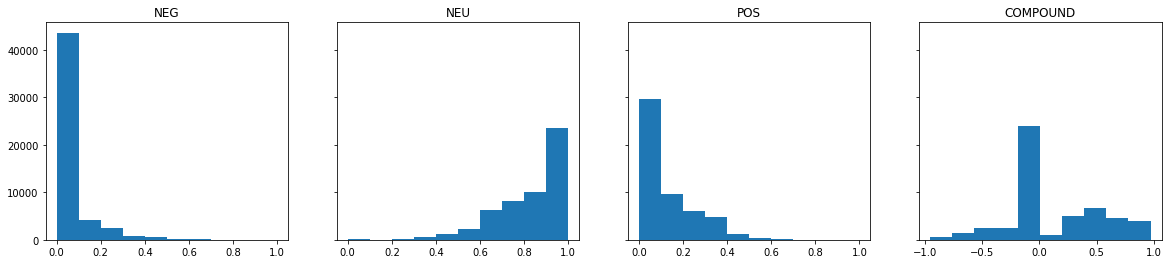

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.hist([score['neg'] for score in scores])
#plt.show()

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(20,4))
#f.figsize(15,15)
ax1.hist([score['neg'] for score in scores])
ax1.set_title('NEG')
ax2.hist([score['neu'] for score in scores])
ax2.set_title('NEU')
ax3.hist([score['pos'] for score in scores])
ax3.set_title('POS')
ax4.hist([score['compound'] for score in scores])
ax4.set_title('COMPOUND')
plt.show()